In [1]:
# Python 3.9. Anaconda recommended.
# -- Prerequisites install 
#%pip install ipykernel --user
#%pip install stable_baselines3 --user
#%pip install tensorboard --user
#%pip install torch --index-url https://download.pytorch.org/whl/cu117 --upgrade --force-reinstall --trusted-host pypi.org --trusted-host pytorch.org --trusted-host download.pytorch.org --no-cache --user


# STABLEBASELINES TESTBED

In [1]:
# Battery env 
import gymnasium as gym
import numpy as np
from typing import Optional, Union
import itertools
import math

from datetime import datetime


import sys
sys.path.append("../../cell_simulation")

import sys
sys.path.append("../../cell_simulation")

import SimCellPack as scp



#class BatteryEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):

class BatteryEnv(gym.Env):

   def __init__(self, cellModel, numCells, simCycles, seed, balancing, sampleFactor, utilization, render_mode: Optional[str] = None):
      super().__init__()

      self.env_id = "Battery v0.4"
      self.num_envs = 1

      self.numCells = numCells

      # Define cell model simualtor 
      self.cellModel = scp.SimCellPack(cellModel = cellModel, numCells = numCells, simCycles = simCycles, seed = seed, balancing = balancing, sampleFactor = sampleFactor, utilization=utilization)
      self.cellModel.startSim()

   
      self.soc_threshold_upper = 0.85
      self.soc_threshold_lower = 0.15


      self.action_space = gym.spaces.Box(-1, 1, (self.numCells,), dtype=np.float32)       # current applied to cell1,cell2,cell3...
      self.observation_space = gym.spaces.Box(0, 1, (self.numCells,), dtype=np.float32)   # SOCs for cell1, cell2, cell3...


      self.episode_time = 0
      self.state = None

      self.stop_rewards = False
      



   def step(self, action):
      err_msg = f"{action!r} ({type(action)}) invalid"
      assert self.action_space.contains(action), err_msg
      assert self.state is not None, "Call reset before using step method."

      self.episode_time += 1

      # Scale the action space between 0 and 1
      battery_current_values = get_converted_action(action)


      # stop any distcharge on the smallest SOC
      initial_min_soc = min(self.state)
      index_initial_min_soc = self.state.index(initial_min_soc)
      battery_current_values[index_initial_min_soc] = 0.0
      action[index_initial_min_soc] = -1.0

      nr_cells_already_balanced = 0
      for soc_index in range(0, len(self.state)):
         if soc_index != index_initial_min_soc: 
            if math.isclose(self.state[soc_index], initial_min_soc, abs_tol=0.001):
               nr_cells_already_balanced = nr_cells_already_balanced + 1 
      

      if nr_cells_already_balanced == (len(self.state) -1 ):
         for i in range(0, len(self.state)):
            battery_current_values[i] = 0.0
            action[i] = -1.0


      # Send the action as feedback to the cell model
      self.cellModel.sendSimFeedback(battery_current_values)

      # Flags for determining certain occurences
      terminated = False
      truncated = False

      # Save state before action
      initial_state = self.state

      #Apply action to state
      code, self.state = self.cellModel.getSimStep()

      #print("Step: state: " + str(self.state) + " code: " + str(code))

      # Cell simulation finished, terminate
      if code == 0.0:
         truncated = True

      # Compute reward and termination cases
      # Apply step reward. Continue running.
      
      reward = 0
      # if (self.episode_time > 1200):
      reward, terminated = compute_ballancing_reward(self.state, initial_state, battery_current_values, False)

      # if(self.stop_rewards == True):
      #    reward = 0

      # if ((truncated == True or terminated == True) and self.episode_time < 1000):
      #    reward -= self.episode_time - 1000


      # Return modified
      return np.array(self.state, dtype=np.float32), float(reward), terminated, truncated, {}

   def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None,):
   # Reset runs first before starting the simulation to get the initial states
        
      super().reset(seed=seed)

      now = datetime.now()
      current_time = now.strftime("%H:%M:%S")
      print("!-- RESTARTED AT : ", current_time)

      # Stops and restarts the cell simulation
      self.cellModel.resetSim()

      now = datetime.now()
      current_time = now.strftime("%H:%M:%S")
      print("DONE RESTARTING: ", current_time)


      self.episode_time = 0
      self.stop_rewards = False

      # Get initial states from the cell model
      code, self.state = self.cellModel.getSimStep()

      #print("Reset state: " + str(self.state))

      return np.array(self.state, dtype=np.float32), {}
   

   def __del__(self):
      self.cellModel.stopSim()



#CONVERT ACTION
   
def get_converted_action(action):
   current_values = []
   for current in action:
      shifted_value = ((current + 1.0))/2  #from [-1, 1] to [0, 1], to be reduced from SoC
      current_values.append(shifted_value)

   return current_values


# REWARD CALCULATION HELPERS 

def compute_closeness(socs):
   mean = 0
   for soc in socs:
      mean += soc
   mean = mean/len(socs)

   mean_diff = 0
   for  soc in socs:
      mean_diff += abs(mean - soc)

   mean_diff /= len(socs)

   min = np.array(socs).min()
   max = np.array(socs).max()
   abs_diff_min_max = max - min


   # alternative: (mean_diff), or (mean_diff*05 + abs_diff_min_max*0.5)
   return abs_diff_min_max

# Closeness function debug code
numbers = [0.02, 0.05, 0, 0.01, 0.1]
numbers = [0.8268956, 0.7947008, 0.8274856]
print(compute_closeness(numbers))
print(np.std(numbers, dtype=np.float32))  # standard deviation

# Get reward for a given step
def compute_ballancing_reward(initial_socs, action_socs, action, should_print):



   reward = 0

   initial_min_soc = min(initial_socs)
   action_min_soc = min(action_socs)

   index_initial_min_soc = initial_socs.index(min(initial_socs))
   index_action_min_soc = action_socs.index(min(action_socs))

   if (should_print):
      print("INITIAL MIN SOC :  " + str(initial_min_soc) + "      ACTION  MIN SOC :  " + str(action_min_soc))
      print("INDEX INITIAL MIN SOC :  " + str(index_initial_min_soc) + "      INDEX ACTION  MIN SOC :  " + str(index_action_min_soc))


   # reduce reward for any actions on the minimum SOC
   # if action[index_initial_min_soc] != 0.0:
   #    reward = -10
   terminated = False

   # else:
   # if index_initial_min_soc == index_action_min_soc:
   #    for soc_index in range(0, len(initial_socs)):
   #       if soc_index != index_initial_min_soc:         
   #          initial_diff_to_min = initial_socs[soc_index] - initial_min_soc
   #          action_diff_to_min = action_socs[soc_index] - action_min_soc
         
   #          if (should_print):
   #                print(str(initial_socs[soc_index])  + " ---> " + str(action_socs[soc_index]))
   #                print("Initial diff :  " + str(initial_diff_to_min))
   #                print("Action diff  :  " + str(action_diff_to_min))
   #                print ("----------")


   #          if action_diff_to_min <= 0.01:
   #                reward += - pow((action_diff_to_min * 10), 2)
   #          elif action_diff_to_min < initial_diff_to_min:
   #                reward -= pow((action_diff_to_min * 10), 2)
   #          # elif action_diff_to_min > initial_diff_to_min:
   #          #       reward -= (action_diff_to_min - initial_diff_to_min)
   #          else:
   #             reward -= action_diff_to_min * 100
         

   #       # penalty for amount of SOC discharged (this takes leakeage current as well, though assume its negligible)
   #       # reward = reward*0.8 - (initial_socs[soc_index] - action_socs[soc_index])*10*0.2

   #       if action_socs[soc_index] < 0.10:
   #          reward = -100
   #          terminated = False
         


   # else:
   #    reward = -10000
   #    terminated = False


   reward = 0




   # reward = 0.05-np.std(action_socs, dtype=np.float32)

   # if ()

   # if index_initial_min_soc == index_action_min_soc:
   #    reward = -0.002

   # reward2 = 0


   # check how many SOCs are already balanced (initial state)
   # nr_cells_already_balanced = 0
   # for soc_index in range(0, len(initial_socs)):
   #    if soc_index != index_initial_min_soc: 
   #       if math.isclose(initial_socs[soc_index], initial_min_soc, abs_tol=0.001):
   #          nr_cells_already_balanced = nr_cells_already_balanced + 1 

   

   # if j == (len(initial_socs) -1 ):
   #    # and ACtions != 0
   #    reward = 1


   # check how many SOCs were balanced after action (state + action)
   nr_cells_balanced_after_action = 0
   for soc_index in range(0, len(action_socs)):
      if soc_index != index_initial_min_soc: 
         # if math.isclose(action_socs[soc_index], action_min_soc, abs_tol=0.001):
         diff = action_socs[soc_index] - action_min_soc
         if diff < 0.001 and diff > 0:
            nr_cells_balanced_after_action = nr_cells_balanced_after_action+1 

   # if all SOCs are balanced after action, reward
   if nr_cells_balanced_after_action == (len(action_socs) -1 ):
      reward = 1

   maxPenaltyPerAction = 1/len(action)
   
   for current in action:
      reward -= maxPenaltyPerAction*current




   # if the penelthy here is too high, it prioritizes no-action
      
   # if was already balanced
   # if nr_cells_already_balanced == (len(initial_socs) -1 ):
   #    # and you still discharged it
   #    if (max(action) > 0.2):
   #       reward = reward - 0.5
      
   #    # and you also unbalanced it
   #    if (nr_cells_already_balanced != nr_cells_balanced_after_action):
   #       reward = -2
   #    # else:
   #    #    reward = 1



      

   #       initial_diff_to_min = initial_socs[soc_index] - initial_min_soc
   #       action_diff_to_min = action_socs[soc_index] - action_min_soc

   #       reward2 += (action_socs[soc_index] - initial_socs[soc_index])
               
   # reward = reward * 0.8 + reward2 * 0.2
   
   # else:
   #    reward = -1


   return reward, terminated






print("-----------")
print("REWARD: " + str(compute_ballancing_reward([0.3801861, 0.33264282, 0.34823087], [0.3801861, 0.33264282, 0.34823087 ], [0.0, 0., 0.0], True)))
print("REWARD: " + str(compute_ballancing_reward([0.7555555, 0.7155555, 0.7555555], [0.725555, 0.7155555, 0.755555 ], [0.0, 0., 0.0], True)))
print("REWARD: " + str(compute_ballancing_reward([0.725555, 0.7155555, 0.7555555], [0.721555, 0.7115555, 0.755555 ], [0.0, 0., 0.0], True)))

print("REWARD: " + str(compute_ballancing_reward([0.725555, 0.7155555, 0.7555555], [0.721555, 0.7115555, 0.735555 ], [0.0, 0., 0.0], True)))
print("REWARD: " + str(compute_ballancing_reward([0.18204315, 0.17318097, 0.17277935], [0.18178657, 0.17259763, 0.17277274], [0.0, 0., 0.0], True)))


print("REWARD: " + str(compute_ballancing_reward([0.7555555, 0.7544555, 0.7555555], [0.7555555, 0.7548555, 0.7555555], [0.15639728, 0.,         1.        ], True)))


# action distribution: the action-reward pair that happens the most will shape the policy the most
# breadcrumb mentality: one reward should lead to another, the agent should be able to quickly get to the biggest reward
# negative rewards: if it gets punidhed per step, it will try to find the quickest way to stop stepping and kill itself.

0.03278480000000006
0.0153177325
-----------
INITIAL MIN SOC :  0.33264282      ACTION  MIN SOC :  0.33264282
INDEX INITIAL MIN SOC :  1      INDEX ACTION  MIN SOC :  1
REWARD: (0.0, False)
INITIAL MIN SOC :  0.7155555      ACTION  MIN SOC :  0.7155555
INDEX INITIAL MIN SOC :  1      INDEX ACTION  MIN SOC :  1
REWARD: (0.0, False)
INITIAL MIN SOC :  0.7155555      ACTION  MIN SOC :  0.7115555
INDEX INITIAL MIN SOC :  1      INDEX ACTION  MIN SOC :  1
REWARD: (0.0, False)
INITIAL MIN SOC :  0.7155555      ACTION  MIN SOC :  0.7115555
INDEX INITIAL MIN SOC :  1      INDEX ACTION  MIN SOC :  1
REWARD: (0.0, False)
INITIAL MIN SOC :  0.17277935      ACTION  MIN SOC :  0.17259763
INDEX INITIAL MIN SOC :  2      INDEX ACTION  MIN SOC :  1
REWARD: (0.0, False)
INITIAL MIN SOC :  0.7544555      ACTION  MIN SOC :  0.7548555
INDEX INITIAL MIN SOC :  1      INDEX ACTION  MIN SOC :  1
REWARD: (0.61453424, False)


# PLOTTING FUNCTIONS:

In [2]:
import matplotlib.pyplot as plt
from IPython import display



def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=1)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    # plt.show()

    display.clear_output(wait=True)
    display.display(plt.gcf())

# plot_results(log_dir)


In [3]:
import stable_baselines3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback


import os
import torch
import numpy as np
from typing import Optional, Union




class PlotResultsCallback(BaseCallback):

    def __init__(self, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.log_dir = log_dir
        self.save_path = None

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        plot_results(self.log_dir)

        return True
    
    



# Initialize environment

In [4]:
# !pip install gymnasium[box2d]
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


# Create log dir
log_dir = "./tmp/gym/pponormtest/"
os.makedirs(log_dir, exist_ok=True)


# Create and wrap the environment
env = BatteryEnv(cellModel="P14", numCells = 3, simCycles = 30, seed=1, balancing="passive", sampleFactor = 30, utilization=0.90, render_mode = False)

#for i in range(0, 100):
#    check_env(env)


# env = DummyVecEnv([lambda: env])
# env = VecNormalize(env, norm_obs=False, norm_reward=True, gamma=0.95)


# Logs will be saved in log_dir/monitor.csv 
env = Monitor(env, log_dir) #monitor for raw environments







# Opt1: Initialize a new model

In [5]:
from stable_baselines3 import A2C, SAC, PPO, TD3


print("Is CUDA enabled?", torch.cuda.is_available())

# PPO 118
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", stats_window_size=3, learning_rate=0.0009, n_epochs=5, batch_size=128)

# ppo 122
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0009, n_steps=2048*4, n_epochs=5, batch_size=32)

# ppo 123 - bad
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0009, n_steps=2048*2, n_epochs=5, batch_size=16)

# ppo 125 - bad - high learning rate makes training unstable
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0015, n_steps=1024, n_epochs=10, batch_size=256)

# ppo 126 - promising, sort of unstable, better eval results than default, also runs faster
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0006, n_steps=1024, n_epochs=10, batch_size=256)

# ppo128
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0006, n_steps=2048, n_epochs=10, batch_size=256*2)

# ppo129 - decent, worse than 126
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0006, n_steps=2048, n_epochs=10, batch_size=256*4)

# ppo130
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0006, n_steps=1024*4, n_epochs=10, batch_size=1024*4)

# ppo131 good
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0006, n_steps=1024*16, n_epochs=10, batch_size=1024*4)

# ppo132
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0006, n_steps=1024*16*3, n_epochs=10, batch_size=1024*4*3)

# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/",  
#             stats_window_size=3, learning_rate=0.0006, n_steps=1024, n_epochs=10, batch_size=256, gamma=0.80)



# DEFAULT MODEL, DEFAULT HYPERPARAMETERS. Stable:  ppo_124
model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", stats_window_size=3, learning_rate=0.0006, batch_size=256)



Is CUDA enabled? True
Using cuda device
Wrapping the env in a DummyVecEnv.


# Opt 2: Load existing trained model from save file

In [12]:
from stable_baselines3 import A2C, SAC, PPO, TD3, DDPG

model = PPO.load(env=env, path=os.path.join(log_dir, "best_model_ppo_cutoffActions_chargerateReward1"))

Wrapping the env in a DummyVecEnv.


# Train model for X timesteps.
Can be interrupted and retain training.

In [7]:
# Eval callback, for plotting and seeing how the training is going, and saving best models. No effect on the results.
# We instantiate the callback only once so on if we keep training the model in future runs, it remember the 'best model' and saves accordingly

# Runs 1 simulation for evaluation every 50000 steps (average episode length ~14000 (!!! this varies a lot based on sample times), so every 5 episodes of training we run 1 eval episode)
# 1 episode = 1 full run of the matlab simulation
callback = EvalCallback(env, log_path=log_dir, n_eval_episodes= 1, eval_freq= 100000,
                            best_model_save_path=os.path.join(log_dir, "best_model_ppo_norm"))


# For callback with plot, add this parameter to the EvalCallback:       callback_on_new_best=PlotResultsCallback(log_dir=log_dir))

In [8]:
from stable_baselines3.common import results_plotter
from stable_baselines3 import A2C, SAC, PPO, TD3


# Run training cycles on the model. (range(0, x))
# Can just be 1 training cycle of many steps, or multiple cycles of fewer steps. 
# Training results are similar as long as it gets to do at least a few episodes within a cycle.

# Around 1 mil steps it should not perform worse than a nonbalancing run (runs with no action from the RL model).
# Nonbalancing runs give around -30000 -35000 total reward for 1 episode

model.learn(total_timesteps=int(300000), callback=callback)



#LOG PRINTS INFO:
    
# rollout/                             
#    ep_len_mean          1.34e+04     
#    ep_rew_mean         -1.33e+05   
#    Episode average length and (total) reward for the last 3 episodes. Can be changed in 

# Plot helper from the library
results_plotter.plot_results(
    [log_dir], 1e7, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)


# POI and TRPO update self.num_timesteps after each rollout (and not each step) because they rely on MPI.
# you might see discrepencies between timesteps in the prints due to this

!-- RESTARTED AT :  09:45:46
DONE RESTARTING:  09:45:46
Logging to ./pponorm_tensorboard_log/PPO_89
-----------------------------
| time/              |      |
|    fps             | 153  |
|    iterations      | 1    |
|    time_elapsed    | 13   |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 171          |
|    iterations           | 2            |
|    time_elapsed         | 23           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0049807467 |
|    clip_fraction        | 0.0615       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.62        |
|    explained_variance   | 0.172        |
|    learning_rate        | 0.0006       |
|    loss                 | 2.04         |
|    n_updates            | 5190         |
|    policy_gradient_loss | -0.00302     |
| 

KeyboardInterrupt: 

### Batch train multiple agents

In [13]:
from stable_baselines3 import A2C, PPO, DDPG, TD3, SAC

from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


# model.learn(total_timesteps=int(1000000), callback=callback)


# action noise
# n_actions = env.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
# modelTD3 = TD3('MlpPolicy', env, verbose=1, device="cuda", action_noise=action_noise, tensorboard_log="./pponorm_tensorboard_log/", stats_window_size=3, learning_rate=0.0006, batch_size=256)
# modelTD3.learn(total_timesteps=int(50000), callback=callback)


# modelSAC = SAC('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", stats_window_size=3, learning_rate=0.0006, batch_size=256, buffer_size=10000)
# modelSAC.learn(total_timesteps=int(250000), callback=callback)

# modelA2C = A2C('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/")
# modelA2C.learn(total_timesteps=int(500000), callback=callback)

# modelDDPG = DDPG('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/")
# modelDDPG.learn(total_timesteps=int(50000), callback=callback)

# model.learn(total_timesteps=int(3000000000), callback=callback)



!-- RESTARTED AT :  09:50:51
DONE RESTARTING:  09:50:51
Logging to ./pponorm_tensorboard_log/DDPG_4
!-- RESTARTED AT :  09:51:12
DONE RESTARTING:  09:51:12


KeyboardInterrupt: 

## Plots

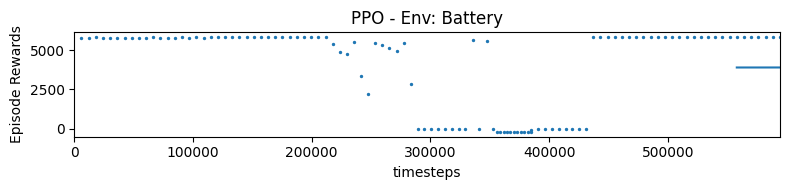

In [22]:

results_plotter.plot_results(
    [log_dir], 1e7, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)

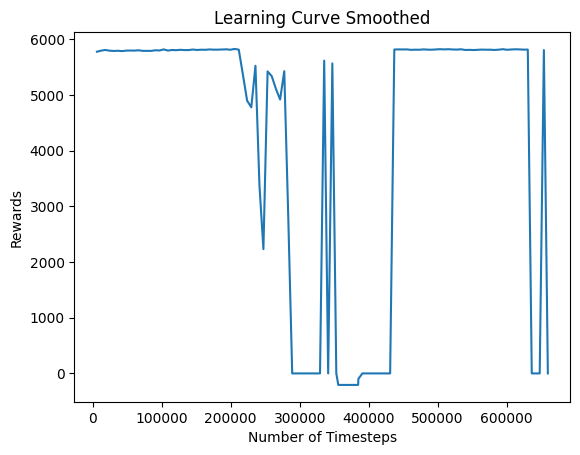

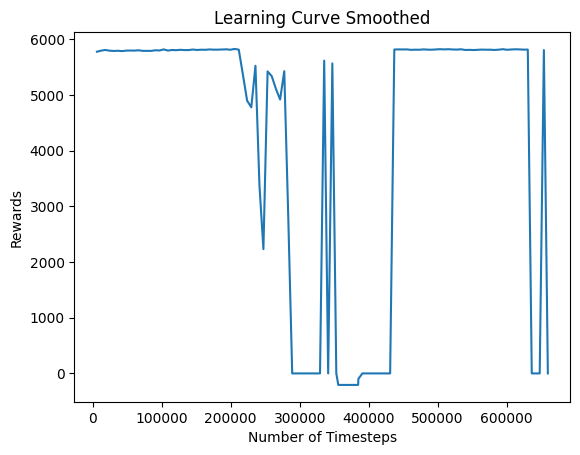

In [51]:

plot_results(log_dir)

In [15]:
def plot_socs_and_diff(obsArray):
    fig = plt.figure(1)

    data_np = np.array(obsArray)

    plt.xlabel('Step')
    plt.ylabel('SOC')
    print("------------------------------------------------------")
    plt.ylim([0, 1])

    i = 0
    for soc in data_np.T:
        plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="soc"+str(i))
        i += 1
    plt.legend()


    fig = plt.figure(1)

    data_diff = []

    i = 0
    for socs in obsArray:
        diff_group = []
        for soc in socs:
            diff = (soc - min(socs.flatten()))*10+0.2
            diff_group.append(diff)
        
        data_diff.append(diff_group)

    data_diff = np.array(data_diff).reshape(-1, 3)

    i = 0
    for soc in data_diff.T:
        plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="diff"+str(i))
        i += 1


    plt.legend()

    return data_diff

### Save trained model

In [ ]:
model.save(os.path.join(log_dir, "best_model_ppo_cutoffActions_chargerateReward"))

# Test 1 episode of the model

!-- RESTARTED AT :  09:55:50
DONE RESTARTING:  09:55:50
NON-ZERO!
NON-ZERO!
  INITIAL STATE:  [0.65148187 0.6513535  0.65490764]  ACTION:[0.71770895 0.         1.        ]
  STATE +ACTION:  [0.6510595  0.6513474  0.65432614]
  DIFFERENCES  :  [0.0, 0.00028789043, 0.0032666326]  >>>>    REWARD:  [-0.57256967]   
-----
NON-ZERO!
NON-ZERO!
  INITIAL STATE:  [0.6510595  0.6513474  0.65432614]  ACTION:[0.         0.06271389 1.        ]
  STATE +ACTION:  [0.6510532  0.6513052  0.65374464]
  DIFFERENCES  :  [0.0, 0.00025200844, 0.0026914477]  >>>>    REWARD:  [-0.35423797]   
-----
NON-ZERO!
  INITIAL STATE:  [0.6510532  0.6513052  0.65374464]  ACTION:[0. 0. 1.]
  STATE +ACTION:  [0.65104693 0.65129906 0.65316314]
  DIFFERENCES  :  [0.0, 0.00025212765, 0.0021162033]  >>>>    REWARD:  [-0.33333334]   
-----
NON-ZERO!
  INITIAL STATE:  [0.65104693 0.65129906 0.65316314]  ACTION:[0.        0.        0.7418953]
  STATE +ACTION:  [0.6510406 0.651293  0.6527302]
  DIFFERENCES  :  [0.0, 0.0002523660

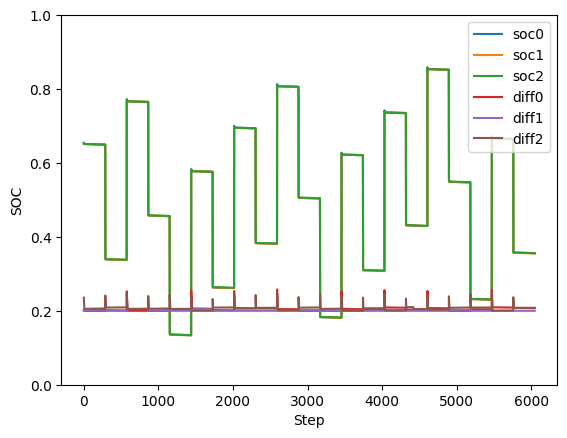

In [19]:
from stable_baselines3 import A2C, SAC, PPO, TD3
import os


# eval_env = BatteryEnv(numCells = 3, simCycles = 2, sampleFactor = 10, render_mode = False)
# model = PPO.load(env=eval_env, path=os.path.join(log_dir, "best_model_ppo_batterysim"))

obs = model.get_env().reset()
episode_reward = 0
obsArray = []

while True:
    obsArray.append(obs.squeeze())
    action, _states = model.predict(obs)
    oldObs = obs
    obs, rewards, done, info = model.get_env().step(action)
    episode_reward += rewards.squeeze()

    if not done:
        # Print step
        for ac in get_converted_action(action.flatten()):
            if ac != 0:
                print("NON-ZERO!")
        print("  INITIAL STATE:  " +str(oldObs.flatten()) + "  ACTION:" + str(get_converted_action(action)[0]))
        print("  STATE +ACTION:  " + str(obs.flatten()) )

        diffs = []
        for o in obs.flatten():
            diffs.append(o - min(obs.flatten()))

        print("  DIFFERENCES  :  " + str(diffs) + "  >>>>  " + "  REWARD:  "  + str(rewards) + "   ")
        print("-----")


    else:
        # Print final step
        info_item = info.pop()
        print("FINAL: ")
        print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
        print(str(get_converted_action(action.flatten())))
        diffs = []
        for o in info_item.get('terminal_observation').flatten():
            diffs.append(o - min(info_item.get('terminal_observation').flatten()))

        print("REWARD:  " + str(rewards[0]))
        print("FINAL DIFFERENCES  :  " + str(diffs) + "  >>>>  " + "  REWARD:  "  + str(rewards) + "   ")
        print("EPISODE TOTAL REWARD: " + str(episode_reward))

        # Plot SOCs and differences
        data_diff = plot_socs_and_diff(obsArray)

        break



### Plot section of grapth

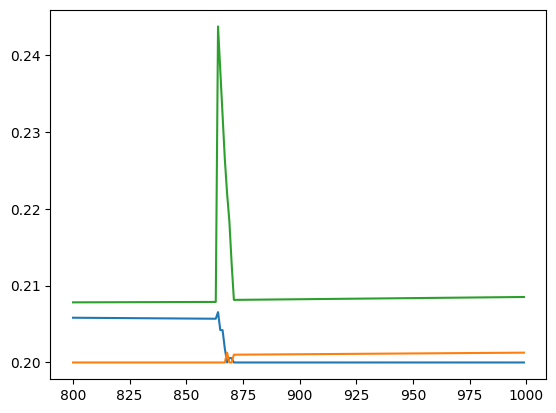

In [ ]:
def plot_diff_section(data_diff, timestep_beginning, timestep_end):
    i = 0
    for soc in data_diff.T:
        plt.plot(np.arange(start=timestep_beginning, stop=timestep_end, step=1), soc.flatten()[timestep_beginning:timestep_end], label="diff"+str(i))
        i += 1



# plot diff section
plot_diff_section(data_diff=data_diff, timestep_beginning=800, timestep_end=1000)


### Sanity check. See if running the simulation with no action from the model gives us similar results

Values for currents are set to 0 and the simulation runs without intervention. No feedback is applied.

!-- RESTARTED AT :  09:53:51
DONE RESTARTING:  09:53:51
NON-ZERO!
NON-ZERO!
  INITIAL STATE:  [0.8577897  0.84760404 0.86560714]  ACTION:[0, 0, 0]
  STATE +ACTION:  [0.8577834  0.84759796 0.8656011 ]
  DIFFERENCES  :  [0.0101854205, 0.0, 0.018003166]  >>>>    REWARD:  [0.]   
-----
NON-ZERO!
NON-ZERO!
  INITIAL STATE:  [0.8577834  0.84759796 0.8656011 ]  ACTION:[0, 0, 0]
  STATE +ACTION:  [0.85777706 0.8475919  0.8655951 ]
  DIFFERENCES  :  [0.010185182, 0.0, 0.018003225]  >>>>    REWARD:  [0.]   
-----
NON-ZERO!
NON-ZERO!
  INITIAL STATE:  [0.85777706 0.8475919  0.8655951 ]  ACTION:[0, 0, 0]
  STATE +ACTION:  [0.85777074 0.84758574 0.8655891 ]
  DIFFERENCES  :  [0.010185003, 0.0, 0.018003345]  >>>>    REWARD:  [0.]   
-----
NON-ZERO!
NON-ZERO!
  INITIAL STATE:  [0.85777074 0.84758574 0.8655891 ]  ACTION:[0, 0, 0]
  STATE +ACTION:  [0.8577644  0.84757966 0.86558306]
  DIFFERENCES  :  [0.010184765, 0.0, 0.018003404]  >>>>    REWARD:  [0.]   
-----
NON-ZERO!
NON-ZERO!
  INITIAL STATE:  [

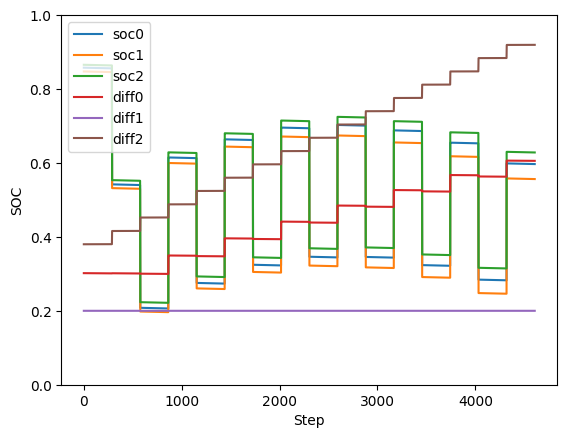

In [18]:
obs = model.get_env().reset()
episode_reward = 0
obsArray = []

while True:
    obsArray.append(obs)
    action, _states = model.predict(obs)
    oldObs = obs
    obs, rewards, done, info = model.get_env().step([[-1, -1, -1]])
    episode_reward += rewards.squeeze()

    if not done:
        # Print step
        for ac in get_converted_action(action.flatten()):
            if ac != 0:
                print("NON-ZERO!")
        print("  INITIAL STATE:  " +str(oldObs.flatten()) + "  ACTION:" + str([0, 0, 0]))
        print("  STATE +ACTION:  " + str(obs.flatten()) )

        diffs = []
        for o in obs.flatten():
            diffs.append(o - min(obs.flatten()))

        print("  DIFFERENCES  :  " + str(diffs) + "  >>>>  " + "  REWARD:  "  + str(rewards) + "   ")
        print("-----")

    else:
        # Print final step
        info_item = info.pop()
        print("FINAL: ")
        print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
        print(str(get_converted_action(action.flatten())))
        diffs = []
        for o in info_item.get('terminal_observation').flatten():
            diffs.append(o - min(info_item.get('terminal_observation').flatten()))

        print("REWARD:  " + str(rewards[0]))
        print("FINAL DIFFERENCES  :  " + str(diffs) + "  >>>>  " + "  REWARD:  "  + str(rewards) + "   ")
        print("EPISODE TOTAL REWARD: " + str(episode_reward))

        # Plot SOCs and differences 
        plot_socs_and_diff(obsArray=obsArray)
        break
